In [1]:
import rasterio
from rasterio.plot import show
import numpy as np
from dotenv import dotenv_values
from elasticsearch import Elasticsearch
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from pystac_client import Client  
from tqdm import tqdm
import requests

# HLS IDS

In [2]:
hls_ids = ['HLS.S30.T14RNV.2021254T170849.v2.0',
            'HLS.S30.T14RNV.2021279T171211.v2.0',
            'HLS.S30.T14RNV.2021319T171601.v2.0',
            'HLS.S30.T14RNV.2021359T171731.v2.0',
            'HLS.L30.T14RNV.2022003T170902.v2.0',
            'HLS.L30.T14RNV.2022036T170252.v2.0',
            'HLS.S30.T14RNV.2022069T171029.v2.0',
            'HLS.L30.T14RNV.2022092T170220.v2.0',
            'HLS.L30.T14RNV.2022132T170214.v2.0',
            'HLS.L30.T14RNV.2022156T170240.v2.0',
            'HLS.S30.T14RNV.2022189T170859.v2.0',
            'HLS.S30.T14RNV.2022214T170901.v2.0']

# Get DSWx Dataset

## Elastic Search bookkeeping

My `.env` file would look like

```
ES_USERNAME=<JPL_USERNAME>
ES_PASSWORD=<JPL_PASSWORD>
```

In [3]:
config = dotenv_values()
ES_USERNAME = config['ES_USERNAME']
ES_PASSWORD = config['ES_PASSWORD']

In [4]:
GRQ_URL = 'https://100.104.62.10/grq_es/'
grq_client = Elasticsearch(GRQ_URL, 
                           http_auth=(ES_USERNAME, ES_PASSWORD), 
                           verify_certs=False, 
                           read_timeout=50000, 
                           terminate_after=2500,
                          )
grq_client.ping()

/Users/cmarshak/opt/anaconda3/envs/dswx_val/lib/python3.10/site-packages/elasticsearch/connection/http_urllib3.py:209: UserWarning: Connecting to https://100.104.62.10:443 using SSL with verify_certs=False is insecure.
  warnings.warn(
/Users/cmarshak/opt/anaconda3/envs/dswx_val/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '100.104.62.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/cmarshak/opt/anaconda3/envs/dswx_val/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '100.104.62.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


True

In [5]:
STAC_URL = 'https://cmr.earthdata.nasa.gov/stac'


def get_hls_metadata(hls_id: str):
    api = Client.open(f'{STAC_URL}/LPCLOUD/')
    hls_collections = ['HLSL30.v2.0', 'HLSS30.v2.0']
    search = Search(using=grq_client, 
                # wildcard is where the version is
                index='grq_*_l3_dswx_hls')


    search_params = {"collections": hls_collections,
                     "ids": [hls_id],
                     "max_items": 100}
    search_hls = api.search(**search_params)
    resp = search_hls.get_all_items()

    data = list(resp)
    if len(data) > 1:
        raise ValueError('Multiple DSWx Products for current query')
    if len(data) == 0:
        raise ValueError('No matches!')
    return data[0].to_dict()

def get_hls_date(hls_id: str):
    metadata = get_hls_metadata(hls_id)
    datetime = metadata['properties']['datetime']
    date = datetime.split('T')[0]
    return date


def _get_urls(data: dict) -> list:
    base_url = data['browse_urls'][0]
    base_url = base_url.replace('s3-website-us-west-2', 's3.us-west-2').replace('browse', 'products')
    all_file_names = [file_data['FileName'] for file_data in data['metadata']['Files']]
    
    urls = [f'{base_url}/{file_name}' for file_name in all_file_names]
    urls = [url.replace('http://', 'https://') for url in urls]

    return urls


def get_DSWX_doc(hls_id: str) -> dict:
    search = Search(using=grq_client, 
                # wildcard is where the version is
                index='grq_*_l3_dswx_hls')

    tokens = hls_id.split('.')
    token_1 = tokens[2]
    token_2 = get_hls_date(hls_id).replace('-', '')
    
    q_qs = Q('query_string', 
             query=f'\"{token_1} {token_2}\"', 
             default_field="id")

   
    query = search.query(q_qs)
    resp = query.execute()
    n = len(resp.hits)
    if n > 1:
        raise ValueError('Multiple DSWx Products for current query')
    if n == 0:
        raise ValueError('No DSWx products match HLS ID')
    data = resp.hits[0].to_dict()
    return data

def get_DSWx_urls(hls_id: str) -> list:
    doc = get_DSWX_doc(hls_id)
    return _get_urls(doc)


def get_hls_urls(hls_id: str) -> dict:
    metadata = get_hls_metadata(hls_id)
    image_urls_dict = {band: metadata['assets'][band]['href'] 
                       for band in ['B01','B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'Fmask']}
    return image_urls_dict

## Get URLS

In [6]:
hls_url_dicts = [get_hls_urls(hls_id) for hls_id in tqdm(hls_ids)]
hls_url_dicts[0]

100%|█████████████████████████████████████| 12/12 [00:07<00:00,  1.57it/s]


{'B01': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T14RNV.2021254T170849.v2.0/HLS.S30.T14RNV.2021254T170849.v2.0.B01.tif',
 'B02': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T14RNV.2021254T170849.v2.0/HLS.S30.T14RNV.2021254T170849.v2.0.B02.tif',
 'B03': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T14RNV.2021254T170849.v2.0/HLS.S30.T14RNV.2021254T170849.v2.0.B03.tif',
 'B04': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T14RNV.2021254T170849.v2.0/HLS.S30.T14RNV.2021254T170849.v2.0.B04.tif',
 'B05': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T14RNV.2021254T170849.v2.0/HLS.S30.T14RNV.2021254T170849.v2.0.B05.tif',
 'B06': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T14RNV.2021254T170849.v2.0/HLS.S30.T14RNV.2021254T170849.v2.0.B06.tif',
 'B07': 'https://data.lpdaac

In [7]:
dswx_urls = [get_DSWx_urls(hls_id) for hls_id in tqdm(hls_ids)]
dswx_urls[0]

  0%|                                              | 0/12 [00:00<?, ?it/s]/Users/cmarshak/opt/anaconda3/envs/dswx_val/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '100.104.62.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
  8%|███▏                                  | 1/12 [00:00<00:09,  1.13it/s]/Users/cmarshak/opt/anaconda3/envs/dswx_val/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '100.104.62.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
 17%|██████▎                               | 2/12 [00:01<00:08,  1.21it/s]/Users/cmarshak/opt/anaconda3/envs/dswx_val/lib/python3.10/site-packages/urllib3/connectionpoo

['https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_20220915T051135Z_S2B_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_20220915T051135Z_S2B_30_v0.1_B01_WTR.tiff',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_20220915T051135Z_S2B_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_20220915T051135Z_S2B_30_v0.1_B02_BWTR.tiff',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_20220915T051135Z_S2B_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_20220915T051135Z_S2B_30_v0.1_B03_CONF.tiff',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_20220915T051135Z_S2B_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_20220915T051135Z_S2B_30_v0.1_B04_DIAG.tiff',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_2022091

# Visualize!

  0%|                                              | 0/12 [00:00<?, ?it/s]

https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_20220915T051135Z_S2B_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_20220915T051135Z_S2B_30_v0.1_B01_WTR.tiff


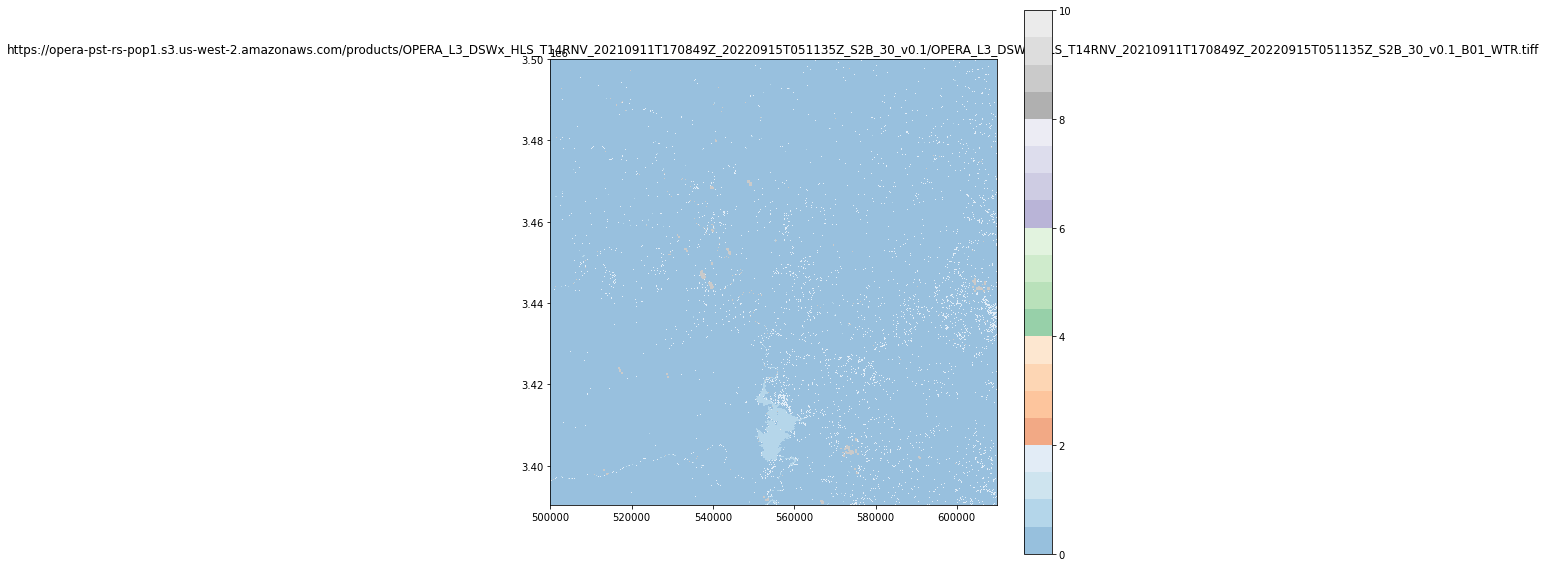

  8%|███▏                                  | 1/12 [00:01<00:16,  1.54s/it]

https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20211006T171211Z_20220915T051226Z_S2A_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20211006T171211Z_20220915T051226Z_S2A_30_v0.1_B01_WTR.tiff


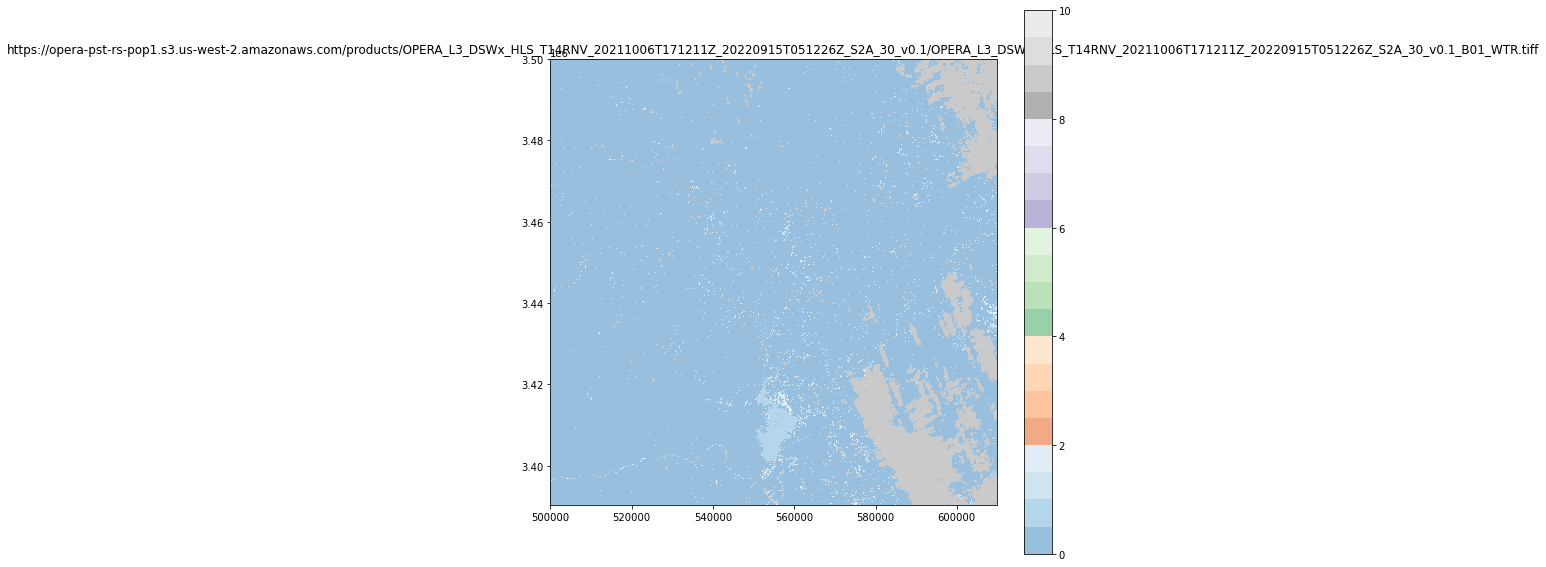

 17%|██████▎                               | 2/12 [00:02<00:12,  1.29s/it]

https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20211115T171601Z_20220915T051212Z_S2A_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20211115T171601Z_20220915T051212Z_S2A_30_v0.1_B01_WTR.tiff


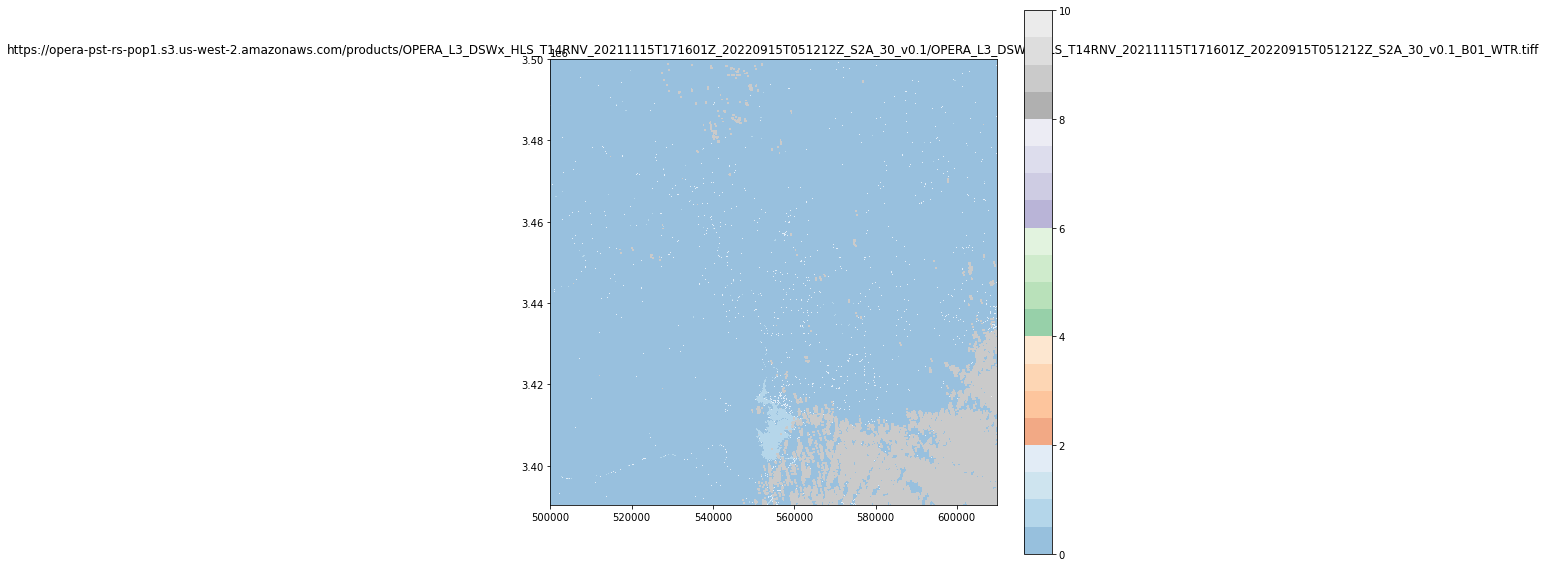

 25%|█████████▌                            | 3/12 [00:03<00:10,  1.19s/it]

https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20211225T171731Z_20220915T032938Z_S2A_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20211225T171731Z_20220915T032938Z_S2A_30_v0.1_B01_WTR.tiff


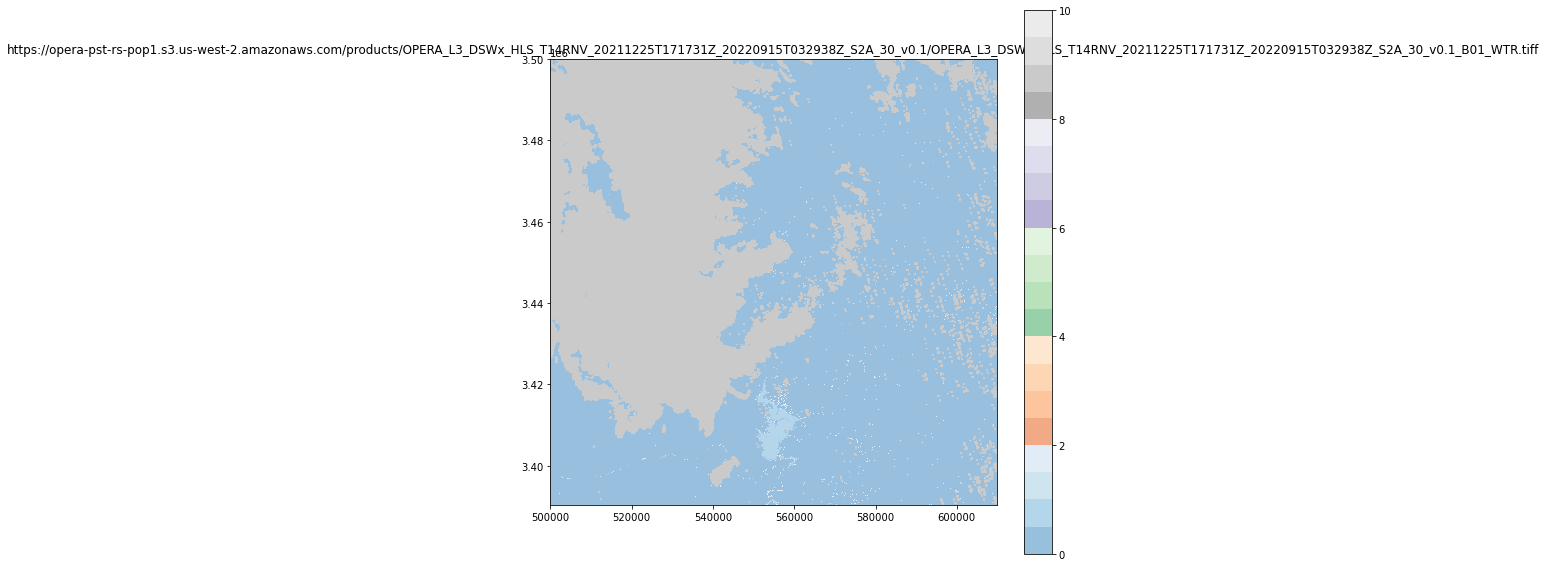

 33%|████████████▋                         | 4/12 [00:04<00:09,  1.14s/it]

https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20220103T170902Z_20220915T051123Z_L8_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20220103T170902Z_20220915T051123Z_L8_30_v0.1_B01_WTR.tiff


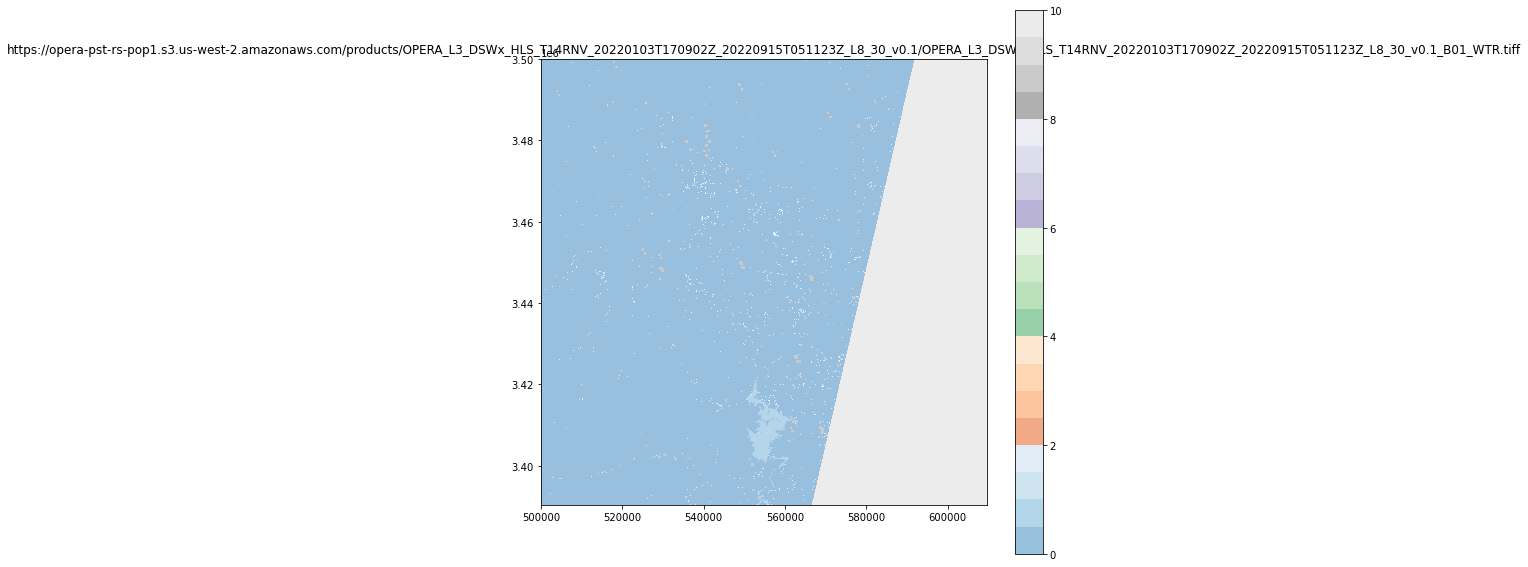

 42%|███████████████▊                      | 5/12 [00:05<00:07,  1.13s/it]

https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20220205T170252Z_20220915T051110Z_L9_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20220205T170252Z_20220915T051110Z_L9_30_v0.1_B01_WTR.tiff


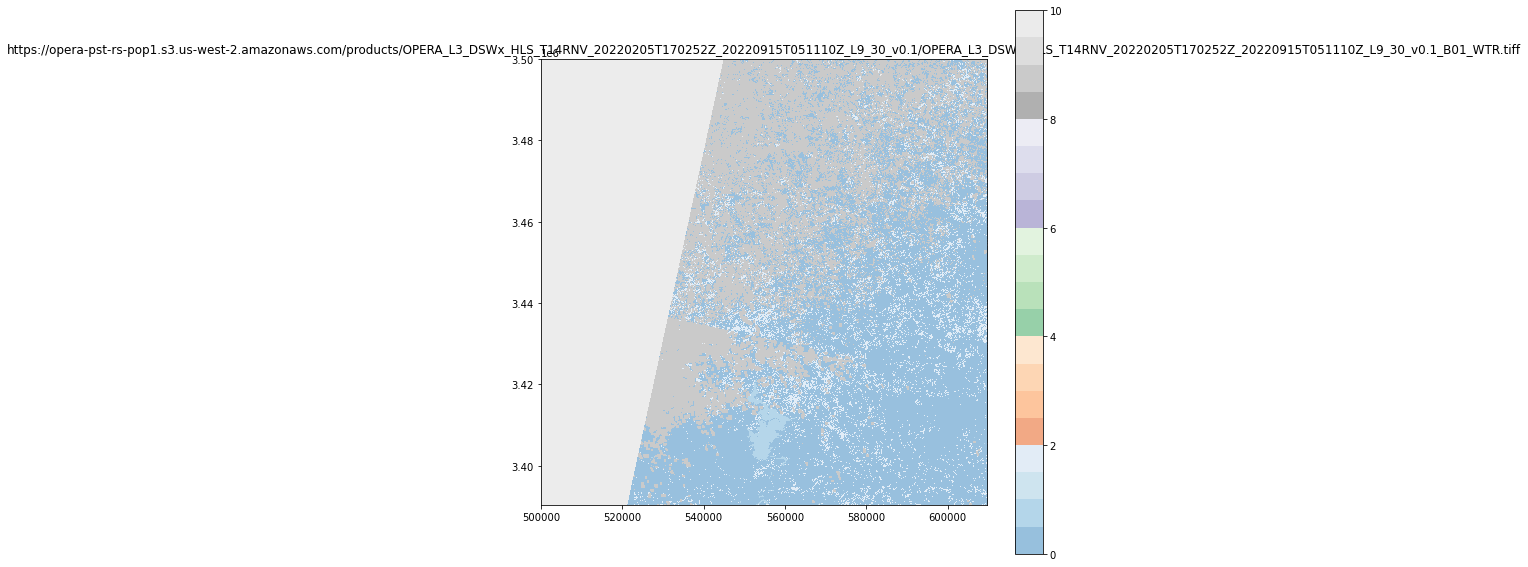

 50%|███████████████████                   | 6/12 [00:07<00:07,  1.17s/it]

https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20220310T171029Z_20220915T032935Z_S2B_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20220310T171029Z_20220915T032935Z_S2B_30_v0.1_B01_WTR.tiff


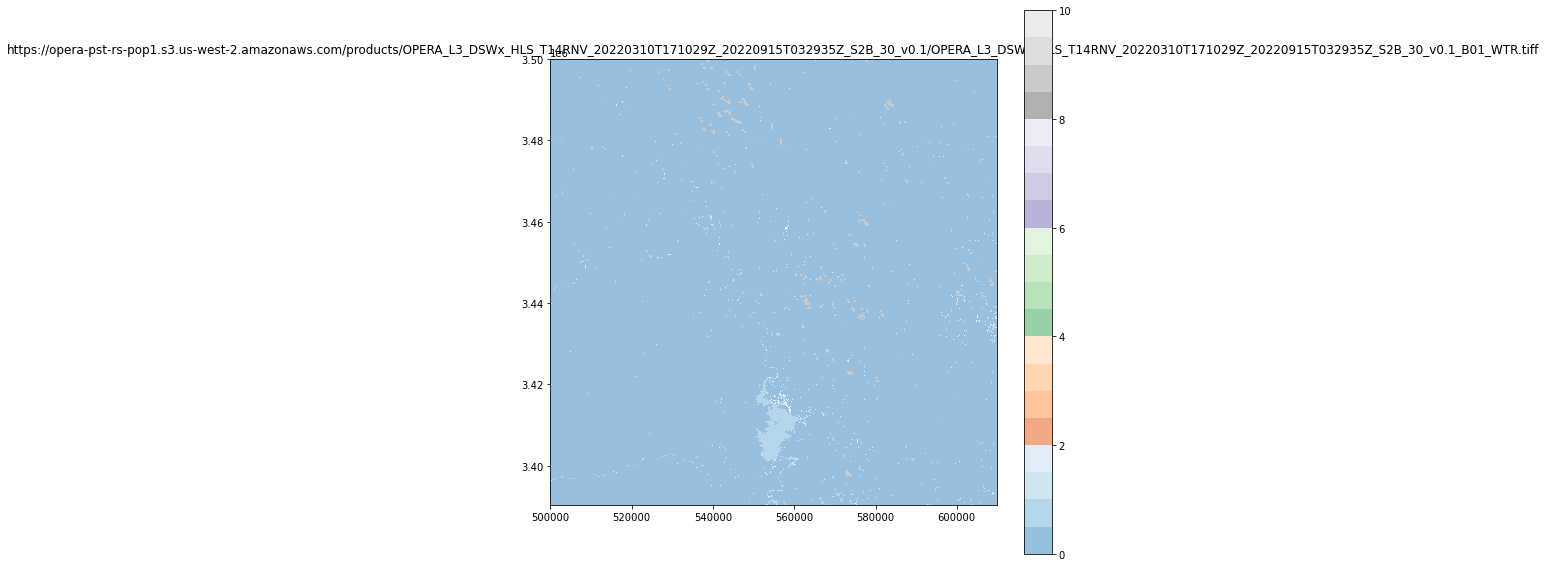

 58%|██████████████████████▏               | 7/12 [00:08<00:05,  1.13s/it]

https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20220402T170220Z_20220915T051107Z_L8_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20220402T170220Z_20220915T051107Z_L8_30_v0.1_B01_WTR.tiff


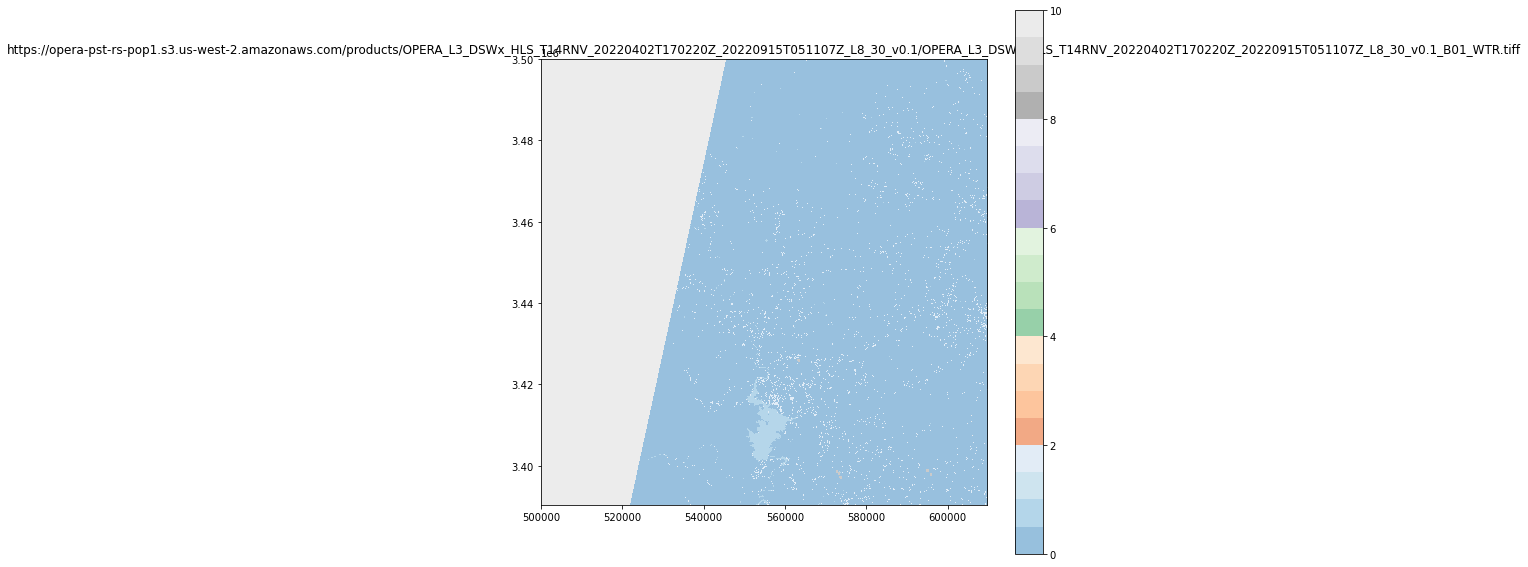

 67%|█████████████████████████▎            | 8/12 [00:09<00:04,  1.14s/it]

https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20220512T170214Z_20220915T050517Z_L9_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20220512T170214Z_20220915T050517Z_L9_30_v0.1_B01_WTR.tiff


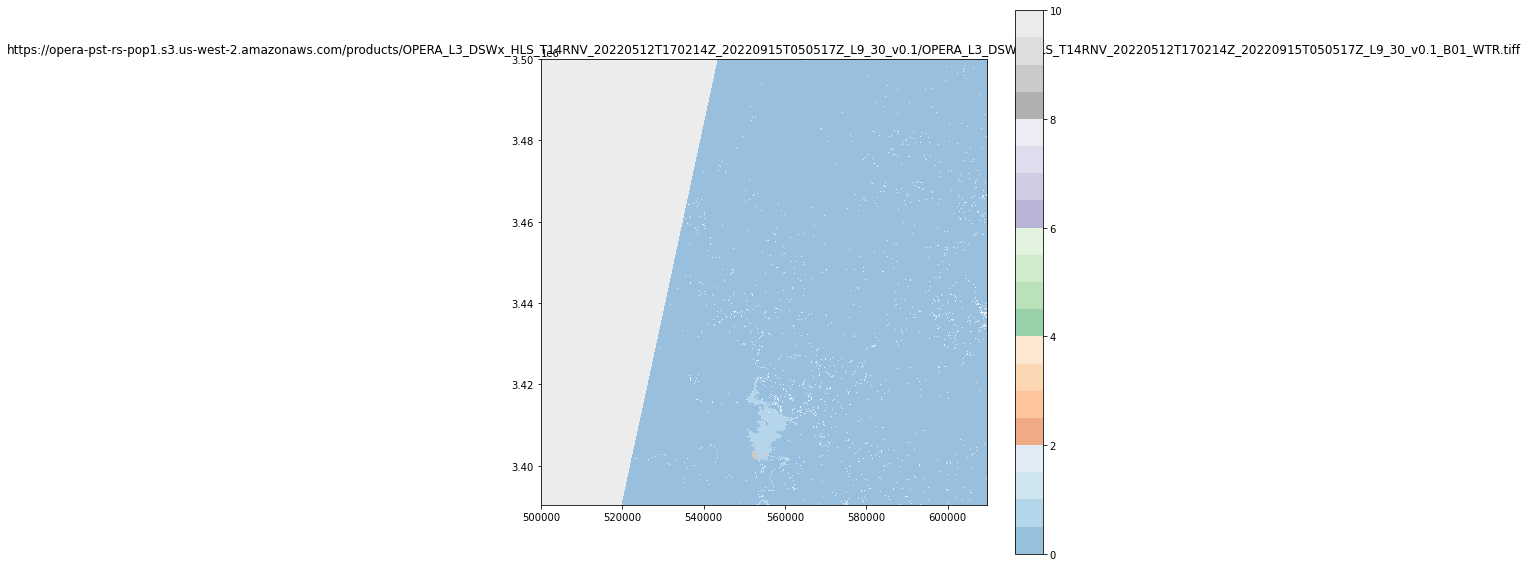

 75%|████████████████████████████▌         | 9/12 [00:10<00:03,  1.11s/it]

https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20220605T170240Z_20220915T051049Z_L8_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20220605T170240Z_20220915T051049Z_L8_30_v0.1_B01_WTR.tiff


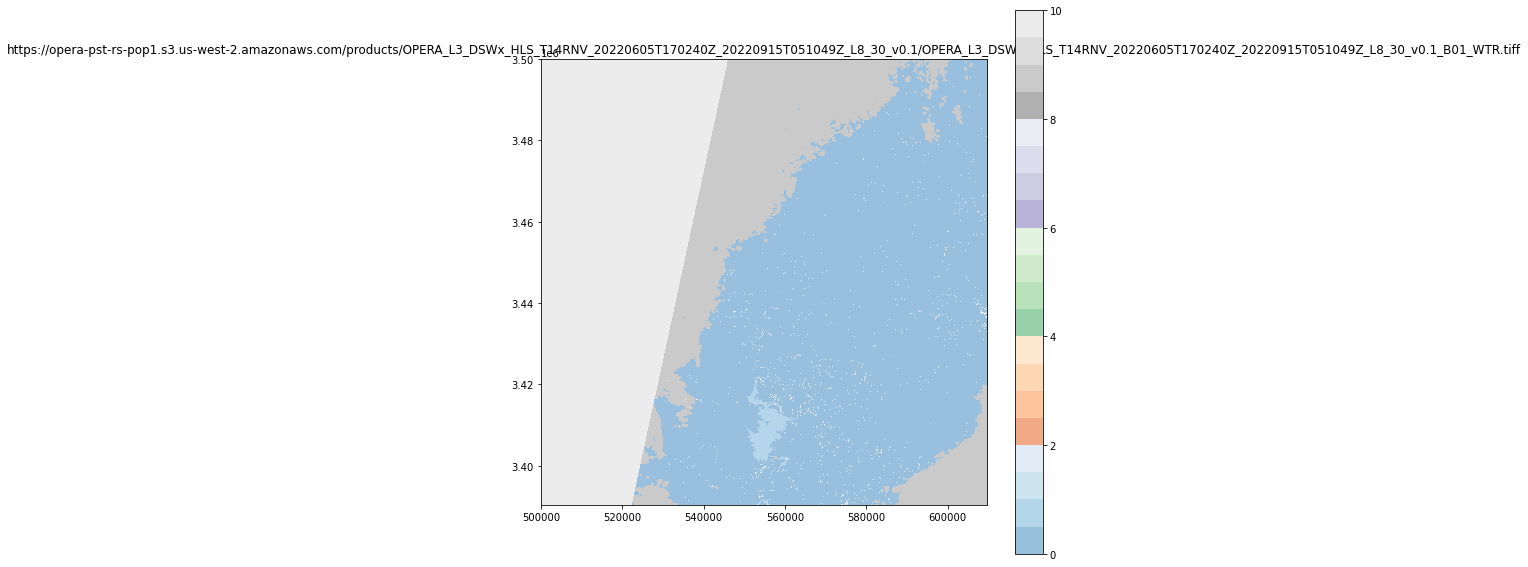

 83%|██████████████████████████████▊      | 10/12 [00:11<00:02,  1.18s/it]

https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20220708T170859Z_20220915T051131Z_S2B_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20220708T170859Z_20220915T051131Z_S2B_30_v0.1_B01_WTR.tiff


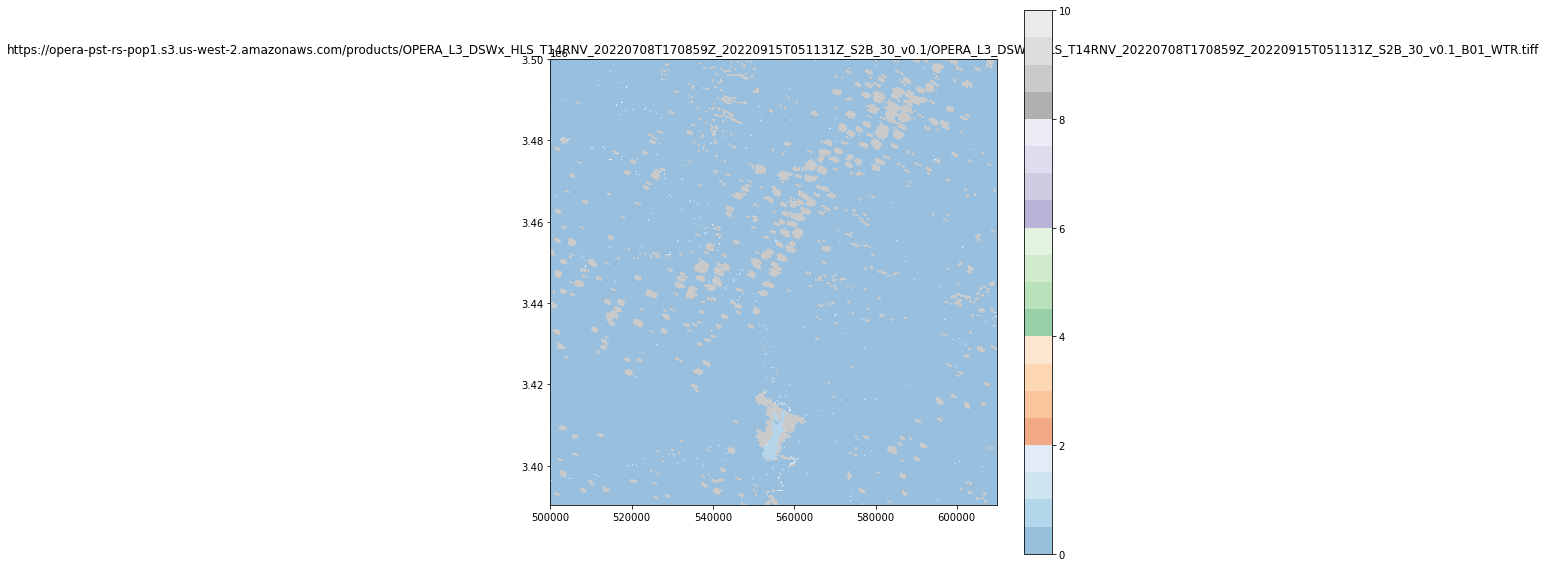

 92%|█████████████████████████████████▉   | 11/12 [00:12<00:01,  1.17s/it]

https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20220802T170901Z_20220915T032455Z_S2A_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20220802T170901Z_20220915T032455Z_S2A_30_v0.1_B01_WTR.tiff


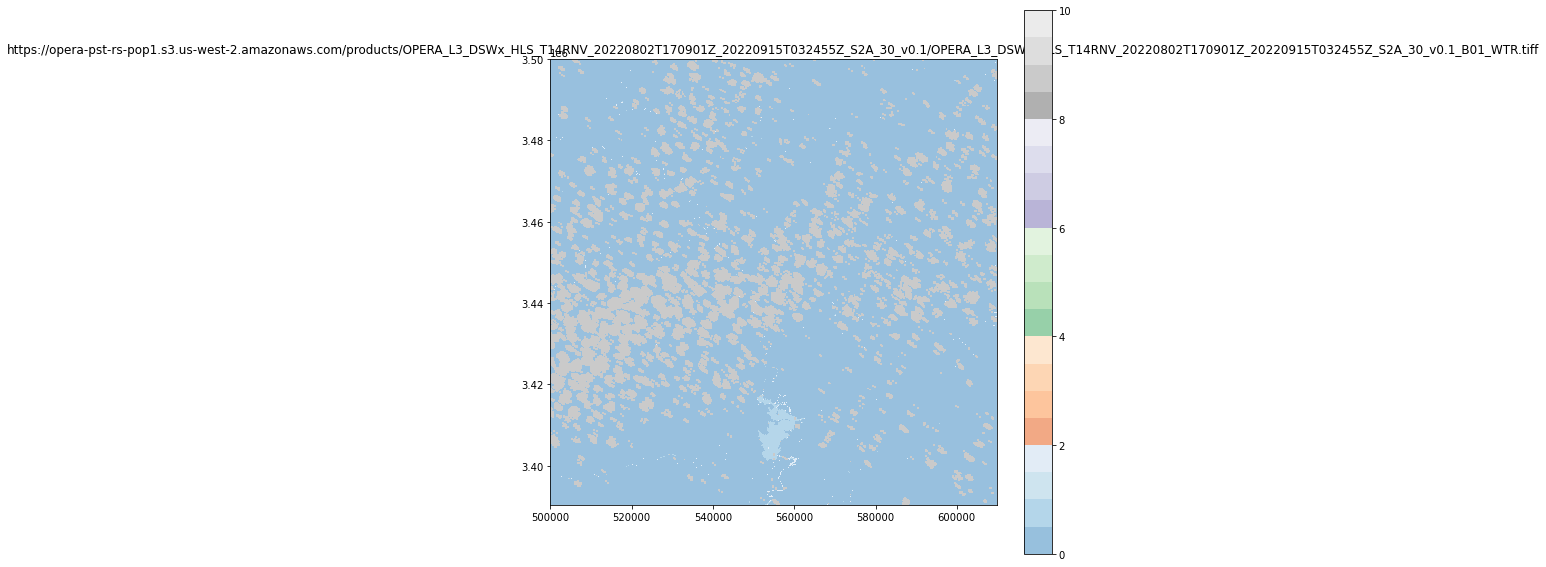

100%|█████████████████████████████████████| 12/12 [00:14<00:00,  1.17s/it]


In [8]:
for url_group, hls_id in zip(tqdm(dswx_urls), hls_ids):
    fig, ax = plt.subplots(figsize=(10, 10))
    with rasterio.open(url_group[0]) as ds:
        X_dswx = ds.read(1)
        p_dswx = ds.profile
    out = show(X_dswx, transform=p_dswx['transform'], cmap='tab20c', vmax=10, alpha=.5, ax=ax, interpolation='none')
    im = out.get_images()[0]
    fig.colorbar(im, ax=ax)
    ax.set_title(f'{url_group[0]}')
    print(url_group[0])
    plt.show()


# Make a CSV

In [9]:
dswx_url_dicts = [{url.split('_')[-1].replace('.tiff', ''): url for url in url_group}  
                  for url_group in dswx_urls ]
dswx_url_dicts[0]

{'WTR': 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_20220915T051135Z_S2B_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_20220915T051135Z_S2B_30_v0.1_B01_WTR.tiff',
 'BWTR': 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_20220915T051135Z_S2B_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_20220915T051135Z_S2B_30_v0.1_B02_BWTR.tiff',
 'CONF': 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_20220915T051135Z_S2B_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_20220915T051135Z_S2B_30_v0.1_B03_CONF.tiff',
 'DIAG': 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_20220915T051135Z_S2B_30_v0.1/OPERA_L3_DSWx_HLS_T14RNV_20210911T170849Z_20220915T051135Z_S2B_30_v0.1_B04_DIAG.tiff',
 'WTR-1': 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_

In [10]:
records = [{**{'hls_id': hls_id}, **hls_url_dict, **dswx_url_dict} 
           for (hls_id, hls_url_dict, dswx_url_dict) in zip(hls_ids, hls_url_dicts, dswx_url_dicts)]
records[0]

{'hls_id': 'HLS.S30.T14RNV.2021254T170849.v2.0',
 'B01': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T14RNV.2021254T170849.v2.0/HLS.S30.T14RNV.2021254T170849.v2.0.B01.tif',
 'B02': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T14RNV.2021254T170849.v2.0/HLS.S30.T14RNV.2021254T170849.v2.0.B02.tif',
 'B03': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T14RNV.2021254T170849.v2.0/HLS.S30.T14RNV.2021254T170849.v2.0.B03.tif',
 'B04': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T14RNV.2021254T170849.v2.0/HLS.S30.T14RNV.2021254T170849.v2.0.B04.tif',
 'B05': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T14RNV.2021254T170849.v2.0/HLS.S30.T14RNV.2021254T170849.v2.0.B05.tif',
 'B06': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T14RNV.2021254T170849.v2.0/HLS.S30.T14RNV.2021254T1

In [11]:
df = pd.DataFrame(records)
df.to_csv('data.csv', index=False)

Source: https://stackoverflow.com/a/44299915

In [12]:
dswx_wtr_bytes = [int(requests.get(record['WTR'], stream=True).headers['Content-length'])
                  for record in tqdm(records)]
dswx_wtr_bytes

100%|█████████████████████████████████████| 12/12 [00:03<00:00,  3.47it/s]


[346004,
 341900,
 218879,
 220070,
 198863,
 1064447,
 150643,
 295928,
 215577,
 207269,
 156401,
 243469]

In [13]:
dswx_DEM_bytes = [int(requests.get(record['DEM'], stream=True).headers['Content-length'])
                  for record in tqdm(records)]
dswx_DEM_bytes

100%|█████████████████████████████████████| 12/12 [00:04<00:00,  2.63it/s]


[33313131,
 33313131,
 33313131,
 33313133,
 33313169,
 33312947,
 33313131,
 33313167,
 33312949,
 33312949,
 33312911,
 33312911]

Source: https://stackoverflow.com/a/5194348

In [14]:
from hurry.filesize import size
dswx_wtr_human = [size(bytes_val) for bytes_val in dswx_wtr_bytes]
dswx_wtr_human

['337K',
 '333K',
 '213K',
 '214K',
 '194K',
 '1M',
 '147K',
 '288K',
 '210K',
 '202K',
 '152K',
 '237K']

In [15]:
dswx_dem_human = [size(bytes_val) for bytes_val in dswx_DEM_bytes]
dswx_dem_human

['31M',
 '31M',
 '31M',
 '31M',
 '31M',
 '31M',
 '31M',
 '31M',
 '31M',
 '31M',
 '31M',
 '31M']